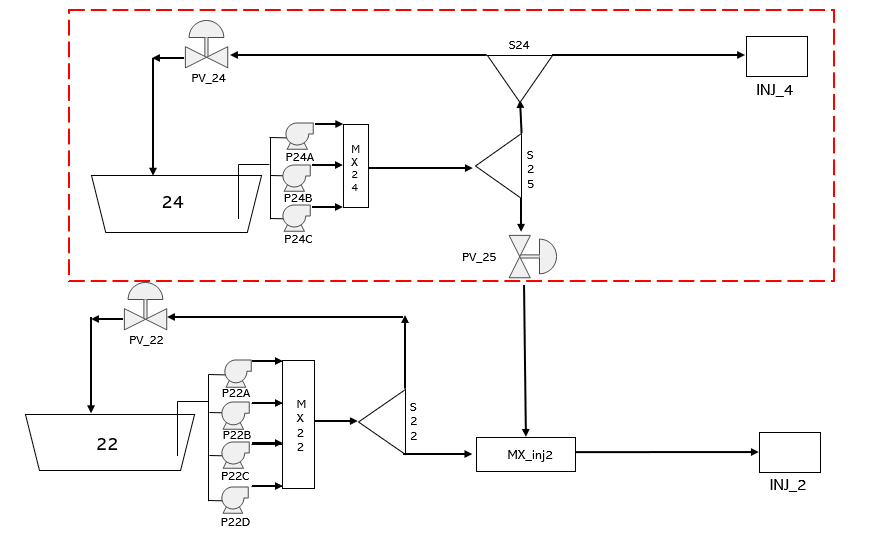

In [251]:
import numpy
from pyomo.environ import ConcreteModel, SolverFactory, value, units,  TransformationFactory  # we import the solver model, object model, and results in units
from idaes.core import FlowsheetBlock # we import the flowsheet to contain our model
from pyomo.network import Arc, SequentialDecomposition
import idaes.logger as idaeslog  # we import to set output levels
from idaes.generic_models.properties import iapws95  # property of ideal water and steam
from idaes.generic_models.properties.helmholtz.helmholtz import (PhaseType)
from idaes.core.util.model_statistics import degrees_of_freedom

In [252]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False}) # false in this case steady state
m.fs.properties = iapws95.Iapws95ParameterBlock(default={"phase_presentation":PhaseType.L}) # we set only liquid water phase is in our system

### PUMPS PARAMETERS

In [253]:
from idaes.generic_models.unit_models.pressure_changer import Pump

In [254]:
m.fs.pump_24_A = Pump(default={"property_package": m.fs.properties}) # we include a pump to our flowsheet 
m.fs.pump_24_B = Pump(default={"property_package": m.fs.properties}) # we include a pump to our flowsheet 
m.fs.pump_24_C = Pump(default={"property_package": m.fs.properties}) # we include a pump to our flowsheet 

In [255]:
DOF_initial = degrees_of_freedom(m)
# help (degrees_of_freedom) # help (func) describes how the function works
print("The initial DOF is {0}".format(DOF_initial)) # we have # inputs to fulffill to make the problem square, those are describe in the unit model

The initial DOF is 15


In [256]:
f_24A = 100
f_24B = 102
f_24C = 100

m.fs.pump_24_A.inlet.flow_mol[0].fix(f_24A) # set properties of flow inlet in this case water inlet (0)
m.fs.pump_24_A.inlet.enth_mol[0].fix(value(iapws95.htpx(T=333.15*units.K, P=101325*units.Pa))) # J/mol # conditions of water inlyer
m.fs.pump_24_A.inlet.pressure[0].fix(101325) # Pa # set properties of pressure in this case water inlet (0)
m.fs.pump_24_A.outlet.pressure[0].fix(1896058) # set pressure outlet 
m.fs.pump_24_A.efficiency_pump.fix(0.75) # set efficiency of the pump 

m.fs.pump_24_B.inlet.flow_mol[0].fix(f_24B) # set properties of flow inlet in this case water inlet (0)
m.fs.pump_24_B.inlet.enth_mol[0].fix(value(iapws95.htpx(T=333.15*units.K, P=101325*units.Pa))) # J/mol # conditions of water inlyer
m.fs.pump_24_B.inlet.pressure[0].fix(101325) # Pa # set properties of pressure in this case water inlet (0)
m.fs.pump_24_B.outlet.pressure[0].fix(1896058) # set pressure outlet 
m.fs.pump_24_B.efficiency_pump.fix(0.9) # set efficiency of the pump 

m.fs.pump_24_C.inlet.flow_mol[0].fix(f_24C) # set properties of flow inlet in this case water inlet (0)
m.fs.pump_24_C.inlet.enth_mol[0].fix(value(iapws95.htpx(T=333.15*units.K, P=101325*units.Pa))) # J/mol # conditions of water inlyer
m.fs.pump_24_C.inlet.pressure[0].fix(101325) # Pa # set properties of pressure in this case water inlet (0)
m.fs.pump_24_C.outlet.pressure[0].fix(1896058) # set pressure outlet 
m.fs.pump_24_C.efficiency_pump.fix(0.6) # set efficiency of the pump 

In [257]:
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final)) # we check to ensure that the system is now square. You should see that the degrees of freedom is now 0.

The final degrees of freedom is: 0


### MIXER PARAMETERS MX_24

In [258]:
 from idaes.generic_models.unit_models.mixer import Mixer

In [259]:
m.fs.MX_24 = Mixer (default={"property_package": m.fs.properties,
                    "inlet_list":[m.fs.pump_24_A.inlet.flow_mol[0], 
                                  m.fs.pump_24_B.inlet.flow_mol[0],
                                  m.fs.pump_24_C.inlet.flow_mol[0]]})

### VALVE PARAMETERS PV_25

In [260]:
from idaes.generic_models.unit_models.valve import Valve

In [261]:
m.fs.PV_25 = Valve (default={"property_package": m.fs.properties})
fin = 202 # mol/s # 🤷‍♂️ how to fis this value as the difference from the product to Water_PAD from the total transfered from the pumps or from the CV of the valve
pin = 1895058 # Pa # 🤷‍♂️ how to fix this with a pressure from from pumps 22
pout = 1007058 # Pa # 🤷‍♂️ how to set this from the CV of the valve 
tin = 340 # K
hin = iapws95.htpx(T=tin*units.K, P=pin*units.Pa) # J/mol
# Calculate the flow coefficient to give 1000 mol/s flow with given P
cv = fin/numpy.sqrt(pin - pout)/0.5
# set inlet
m.fs.PV_25.inlet.enth_mol[0].fix(hin)
m.fs.PV_25.inlet.flow_mol[0].fix(fin)
m.fs.PV_25.inlet.flow_mol[0].unfix()
m.fs.PV_25.inlet.pressure[0].fix(pin)
m.fs.PV_25.outlet.pressure[0].fix(pout)
m.fs.PV_25.Cv.fix(cv)
m.fs.PV_25.valve_opening.fix(0.3)

### VALVE PARAMETERS PV_24

In [262]:
m.fs.PV_24 = Valve (default={"property_package": m.fs.properties})
fin = 0.1 # mol/s # 🤷‍♂️ how to fis this value as the difference from the product to Water_PAD from the total transfered from the pumps or from the CV of the valve
pin = 1895058 # Pa # 🤷‍♂️ how to fix this with a pressure from from pumps 22
pout = 101325 # Pa # 🤷‍♂️ how to set this from the CV of the valve 
tin = 340 # K
hin = iapws95.htpx(T=tin*units.K, P=pin*units.Pa) # J/mol
# Calculate the flow coefficient to give 1000 mol/s flow with given P
cv = fin/numpy.sqrt(pin - pout)/0.5
# set inlet
m.fs.PV_24.inlet.enth_mol[0].fix(hin)
m.fs.PV_24.inlet.flow_mol[0].fix(fin)
m.fs.PV_24.inlet.flow_mol[0].unfix()
m.fs.PV_24.inlet.pressure[0].fix(pin)
m.fs.PV_24.outlet.pressure[0].fix(pout)
m.fs.PV_24.Cv.fix(cv)
m.fs.PV_24.valve_opening.fix(0.01)

### PRODUCT BLOCK PARAMETERS _ Inj_4

In [263]:
from idaes.generic_models.unit_models.product import Product
m.fs.Inj_4 = Product (default={"property_package": m.fs.properties})
f_pad = 100
m.fs.Inj_4.inlet.flow_mol[0].fix(f_pad) 

### SEPARATOR PARAMETERS _ 24

In [264]:
m.fs.S24 = Separator (default={"property_package": m.fs.properties,
                                "outlet_list": [m.fs.Inj_4.inlet.flow_mol[0] , m.fs.PV_24.inlet.flow_mol[0]], 
                                })

### SEPARATOR PARAMETERS_25

In [265]:
from idaes.generic_models.unit_models import Separator

In [266]:
m.fs.S25 = Separator (default={"property_package": m.fs.properties,
                                "outlet_list": [m.fs.S24 , m.fs.PV_25.inlet.flow_mol[0]], 
                                })

### ARCS DEFINITION

In [267]:
m.fs.Arc_24 = Arc(source=m.fs.MX_24.outlet, destination=m.fs.S25.inlet)

In [268]:
TransformationFactory("network.expand_arcs").apply_to(m) # connect the arcs and tranfer the data from the constraints

In [269]:
print("Degrees of freedom on P_24A are", degrees_of_freedom(m.fs.pump_24_A))
print("Degrees of freedom on P_24B are", degrees_of_freedom(m.fs.pump_24_B))
print("Degrees of freedom on P_24C are", degrees_of_freedom(m.fs.pump_24_C))
print("Degrees of freedom on PV_24 are", degrees_of_freedom(m.fs.PV_24))
print("Degrees of freedom on PV_25 are", degrees_of_freedom(m.fs.PV_25))
print("Degrees of freedom on Inj_4 are", degrees_of_freedom(m.fs.Inj_4))
print("Degrees of freedom on MX_24 are", degrees_of_freedom(m.fs.MX_24))
print("Degrees of freedom on S25 are", degrees_of_freedom(m.fs.S25))
print("Degrees of freedom on S24 are", degrees_of_freedom(m.fs.S24))
print("Total degrees of freedom on m are", degrees_of_freedom(m))
# print("Degrees of freedom on Arc_24 are", degrees_of_freedom(m.fs.Arc_24))

Degrees of freedom on P_24A are 0
Degrees of freedom on P_24B are 0
Degrees of freedom on P_24C are 0
Degrees of freedom on PV_24 are 0
Degrees of freedom on PV_25 are 0
Degrees of freedom on Inj_4 are 0
Degrees of freedom on MX_24 are 9
Degrees of freedom on S25 are 4
Degrees of freedom on S24 are 4
Total degrees of freedom on m are 14


In [79]:
# m.fs.S25.split_fraction[0,(m.fs.PV_25,m.fs.S25)]
#iscale.calculate_scaling_factors(m.fs.S25)

In [219]:
%who [m]

No variables match your requested type.


In [ ]:
# m.fs.pump_22_D.initialize(outlvl=idaeslog.INFO) # call this initialize method on the units

In [ ]:
# m.fs.pump_22_D.initialize(outlvl=idaeslog.DEBUG)

In [ ]:
# opt = SolverFactory('ipopt') # set solver 
# solve_status = opt.solve(m.fs.pump_22_D, tee=True) # set the solver status

In [ ]:
# m.fs.pump_22_D.report()